### Install necessary dependencies

In [1]:
!pip install transformers --quiet
!pip install seaborn --quiet
!pip install sklearn --quiet


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issu

In [2]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

c:\Sevann\UBA\procesamiento_lenguaje_natural\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define constants and utility functions

In [3]:
MAX_LENGTH = 140
BATCH_SIZE = 32
EPOCHS = 5
LERARNING_RATE = 2e-5

### Load and Prepare the BERT Model

In [4]:
def load_bert_model(trainable=False):
    model = TFBertModel.from_pretrained("bert-base-uncased")
    model.bert.trainable = trainable
    return model

### Build the Model Architecture

In [5]:
def build_classification_model(num_classes, bert_model, max_length=140, learning_rate=2e-5):
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    
    x = tf.keras.layers.Dropout(0.2)(pooled_output)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

### Load and Prepare the Data

In [6]:
def load_data(filepath):
    return pd.read_csv(filepath)

def preprocess_data(df, target_col, num_classes):
    y = tf.keras.utils.to_categorical(df[target_col].values, num_classes=num_classes)
    sentences = df['content'].values    
    return sentences, y

def tokenize_data(tokenizer, sentences, max_length=140):
    tokens = tokenizer(sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

### Train and Evaluate the Model

In [7]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs=5):
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)
    return history

def evaluate_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    print(classification_report(y_test, y_pred, target_names=class_names))
    
def plot_training_history(history, title):
    """Plot training accuracy and loss"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Training and Validation Loss')
    plt.show()

# Excecution

# 1. Load the BERT model

In [9]:
bert_model = load_bert_model(trainable=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# 2. Load and prepare the data

In [10]:
df = load_data('reviews.csv')

# 3. Process data for 3 classes

In [11]:
df['sentiment_3_classes'] = df.score.apply(lambda x: 0 if x <= 2 else 1 if x == 3 else 2)
class_names_3 = ['negative', 'neutral', 'positive']
sentences_3, y_3_classes = preprocess_data(df, 'sentiment_3_classes', num_classes=3)

# 4. Split and tokenize the data

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
X_train_val, X_test, y_train_val, y_test_3_classes = train_test_split(sentences_3, y_3_classes, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

X_train = X_train.tolist()
X_val = X_val.tolist()
X_test = X_test.tolist()

X_train_tokens = tokenize_data(tokenizer, X_train)
X_val_tokens = tokenize_data(tokenizer, X_val)
X_test_tokens = tokenize_data(tokenizer, X_test)

c:\Sevann\UBA\procesamiento_lenguaje_natural\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# 5. Build and train the model for 3 classes

In [13]:
model_3_classes = build_classification_model(num_classes=3, bert_model=bert_model, max_length=MAX_LENGTH, learning_rate=LERARNING_RATE)
history_3_classes = train_and_evaluate_model(model_3_classes, [X_train_tokens[0], X_train_tokens[1]], y_train, [X_val_tokens[0], X_val_tokens[1]], y_val, epochs=EPOCHS)

Epoch 1/5


315/315 [==============================] - 1687s 5s/step - loss: 1.0944 - accuracy: 0.4222 - val_loss: 0.9993 - val_accuracy: 0.5119
Epoch 2/5
315/315 [==============================] - 1748s 6s/step - loss: 1.0052 - accuracy: 0.4939 - val_loss: 0.9893 - val_accuracy: 0.4607
Epoch 3/5
315/315 [==============================] - 1548s 5s/step - loss: 0.9693 - accuracy: 0.5222 - val_loss: 0.9097 - val_accuracy: 0.5599
Epoch 4/5
315/315 [==============================] - 2232s 7s/step - loss: 0.9646 - accuracy: 0.5191 - val_loss: 0.9275 - val_accuracy: 0.5214
Epoch 5/5
315/315 [==============================] - 1981s 6s/step - loss: 0.9570 - accuracy: 0.5354 - val_loss: 0.9761 - val_accuracy: 0.5036


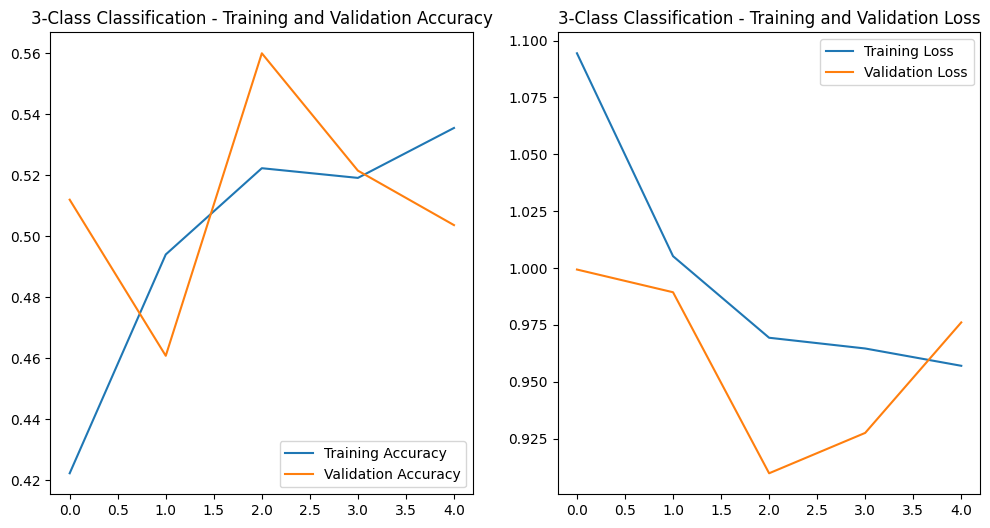

In [14]:
plot_training_history(history_3_classes, title="3-Class Classification")

# 6. Evaluate the model for 3 classes

In [15]:
evaluate_model(model_3_classes, [X_test_tokens[0], X_test_tokens[1]], y_test_3_classes, class_names_3)

99/99 [==============================] - 448s 4s/step
              precision    recall  f1-score   support

    negative       0.63      0.43      0.51       997
     neutral       0.44      0.08      0.14       979
    positive       0.48      0.93      0.63      1174

    accuracy                           0.51      3150
   macro avg       0.51      0.48      0.42      3150
weighted avg       0.51      0.51      0.44      3150



# 7. Process data for 5 classes

In [16]:
df['sentiment_5_classes'] = df.score.apply(lambda x: x - 1)
class_names_5 = ['1', '2', '3', '4', '5']
sentences_5, y_5_classes = preprocess_data(df, 'sentiment_5_classes', num_classes=5)

# 8. Split and tokenize the data

In [17]:
X_train_val, X_test, y_train_val, y_test_5_classes = train_test_split(sentences_5, y_5_classes, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

X_train = X_train.tolist()
X_val = X_val.tolist()
X_test = X_test.tolist()

X_train_tokens = tokenize_data(tokenizer, X_train)
X_val_tokens = tokenize_data(tokenizer, X_val)
X_test_tokens = tokenize_data(tokenizer, X_test)

# 9. Build and train the model for 5 classes

In [18]:
model_5_classes = build_classification_model(num_classes=5, bert_model=bert_model, max_length=MAX_LENGTH, learning_rate=LERARNING_RATE)
history_5_classes = train_and_evaluate_model(model_5_classes, [X_train_tokens[0], X_train_tokens[1]], y_train, [X_val_tokens[0], X_val_tokens[1]], y_val, epochs=EPOCHS)

Epoch 1/5
315/315 [==============================] - 2012s 6s/step - loss: 1.6019 - accuracy: 0.2948 - val_loss: 1.4328 - val_accuracy: 0.4278
Epoch 2/5
315/315 [==============================] - 1998s 6s/step - loss: 1.4983 - accuracy: 0.3461 - val_loss: 1.4203 - val_accuracy: 0.3964
Epoch 3/5
315/315 [==============================] - 2013s 6s/step - loss: 1.4571 - accuracy: 0.3622 - val_loss: 1.3821 - val_accuracy: 0.4036
Epoch 4/5
315/315 [==============================] - 2056s 7s/step - loss: 1.4281 - accuracy: 0.3838 - val_loss: 1.3733 - val_accuracy: 0.4103
Epoch 5/5
315/315 [==============================] - 2079s 7s/step - loss: 1.4271 - accuracy: 0.3890 - val_loss: 1.3449 - val_accuracy: 0.4492


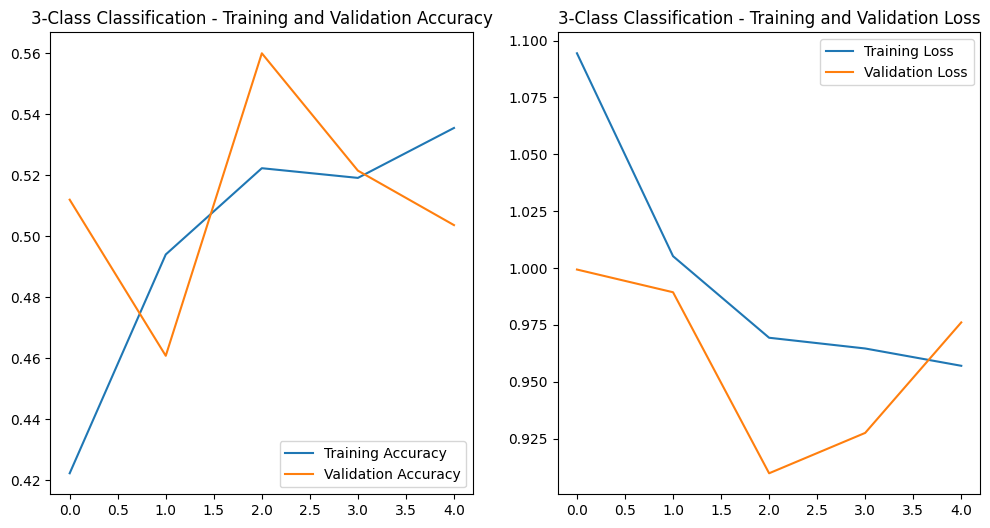

In [19]:
# Plot training history
plot_training_history(history_3_classes, title="3-Class Classification")

# 10. Evaluate the model for 5 classes

In [20]:
evaluate_model(model_5_classes, [X_test_tokens[0], X_test_tokens[1]], y_test_5_classes, class_names_5)

99/99 [==============================] - 447s 4s/step
              precision    recall  f1-score   support

           1       0.42      0.60      0.50       515
           2       0.00      0.00      0.00       482
           3       0.39      0.73      0.51       979
           4       0.47      0.08      0.14       591
           5       0.62      0.54      0.58       583

    accuracy                           0.44      3150
   macro avg       0.38      0.39      0.34      3150
weighted avg       0.39      0.44      0.37      3150



# 11. Ensayos

In [21]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(sentences):
    return bert_tokenizer(sentences, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors='tf')

def analyze_sentence(text, model_3_classes, model_5_classes, class_names_3, class_names_5):
    tokens = tokenize([text])
    
    prediction_3_classes = model_3_classes.predict([tokens['input_ids'], tokens['attention_mask']])
    predicted_class_3 = np.argmax(prediction_3_classes, axis=1)[0]
    
    prediction_5_classes = model_5_classes.predict([tokens['input_ids'], tokens['attention_mask']])
    predicted_class_5 = np.argmax(prediction_5_classes, axis=1)[0]
    
    pred_class_3 = class_names_3[predicted_class_3]
    pred_class_5 = class_names_5[predicted_class_5]
    
    print(f"Frase: {text}")
    print(f"Predicción (3 clases): {pred_class_3}")
    print(f"Predicción (5 clases): {pred_class_5}")
    print()
    
    return pred_class_3, pred_class_5

c:\Sevann\UBA\procesamiento_lenguaje_natural\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
texts = [
    "This app is amazing, I use it every day!",
    "Terrible experience, the app crashes all the time.",
    "It's a decent app, but it has some bugs.",
    "The app is okay, but there are better alternatives.",
    "This app works perfectly."
]

for text in texts:
    analyze_sentence(text, model_3_classes, model_5_classes, class_names_3, class_names_5)

1/1 [==============================] - 0s 81ms/step
Frase: This app is amazing, I use it every day!
Predicción (3 clases): positive
Predicción (5 clases): 5

1/1 [==============================] - 0s 95ms/step
Frase: Terrible experience, the app crashes all the time.
Predicción (3 clases): negative
Predicción (5 clases): 1

1/1 [==============================] - 0s 68ms/step
Frase: It's a decent app, but it has some bugs.
Predicción (3 clases): negative
Predicción (5 clases): 1

1/1 [==============================] - 0s 82ms/step
Frase: The app is okay, but there are better alternatives.
Predicción (3 clases): positive
Predicción (5 clases): 3

1/1 [==============================] - 0s 75ms/step
Frase: This app works perfectly.
Predicción (3 clases): positive
Predicción (5 clases): 5

